# Optimization with bathymetry and max water depth constraint

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/bathymetry.ipynb) (requires google account)


In [0]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

## Install packages if running in Colab

In [8]:
try:
    RunningInCOLAB = 'google.colab' in str(get_ipython())
except NameError:
    RunningInCOLAB = False

In [9]:
%%capture
if RunningInCOLAB:
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
  !pip install scipy==1.6.3 #  constraint is not continuous which trips vers. 1.4.1 which presently is the default version
  import os
  os.kill(os.getpid(), 9)

## Import section

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot, XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.examples.data.parque_ficticio_offshore import ParqueFicticioOffshore

from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines

## Set up site and optimization problem

In [4]:
site = ParqueFicticioOffshore()
site.bounds = 'ignore'
x_init, y_init = site.initial_position[:,0], site.initial_position[:,1]
boundary = site.boundary
# # # Wind turbines and wind farm model definition
windTurbines = IEA37_WindTurbines() 
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines)

wsp = np.asarray([10, 15])
wdir = np.arange(0,360,45)
maximum_water_depth = -52
n_wt = x_init.size
maxiter = 10

def aep_func(x, y, **kwargs):
    simres = wfm(x, y, wd=wdir, ws=wsp)
    aep = simres.aep().values.sum()
    water_depth = np.diag(wfm.site.ds.interp(x=x, y=y)['water_depth'])
    return [aep, water_depth]
    
tol = 1e-8
ec = 1e-2
min_spacing = 260

cost_comp = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=aep_func,
                                          objective=True,
                                          maximize=True,
                                          output_keys=[('AEP', 0), ('water_depth', np.zeros(n_wt))]
                                          )
problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                        constraints=[XYBoundaryConstraint(boundary),
                                      SpacingConstraint(min_spacing)],
                           post_constraints=[('water_depth', {'lower': maximum_water_depth})],
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=XYPlotComp(),
                          expected_cost=ec)


## Optimize

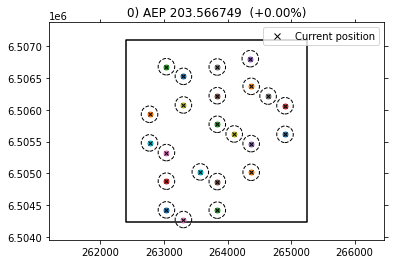

Iteration limit reached    (Exit mode 9)
            Current function value: [-20412.33040188]
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization took: 20s


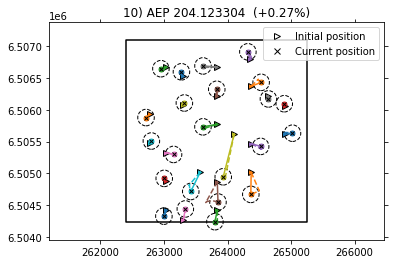

In [5]:
tic = time.time()

cost, state, recorder = problem.optimize()
toc = time.time()
print('Optimization took: {:.0f}s'.format(toc-tic))


## Check the max water depth

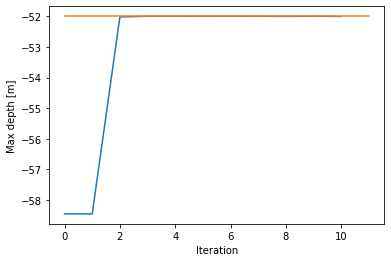

In [6]:
# plt.plot(recorder['water_depth'].min((1)))
# plt.plot([0,recorder['water_depth'].shape[0]],[maximum_water_depth, maximum_water_depth])
# plt.xlabel('Iteration')
# plt.ylabel('Max depth [m]')

## Check the initial- and optimized layout wrt. the water depth boundary 

Text(0.5, 1.0, 'Max Water Depth Boundary: -52 m')

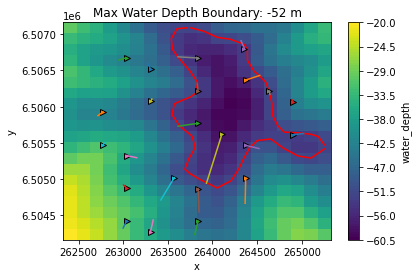

In [7]:
# values = site.ds.water_depth.values
# x = site.ds.x.values
# y = site.ds.y.values
# levels = np.arange(int(values.min()), int(values.max()))
# max_wd_index = int(np.argwhere(levels==maximum_water_depth))
# Y, X = np.meshgrid(y, x)
# cs = plt.contour(x, y , values.T, levels)
# plt.close()
# lines = []
# for line in cs.collections[max_wd_index].get_paths():
#     lines.append(line.vertices)
# fig2, ax2 = plt.subplots(1)

# site.ds.water_depth.plot(ax=ax2, levels=100)
# for line in lines:
#     ax2.plot(line[:, 0], line[:,1], 'r')
# problem.model.plot_comp.plot_initial2current(x_init, y_init, state['x'], state['y'])
# ax2.set_title(f'Max Water Depth Boundary: {maximum_water_depth} m')